<img src="./files/qsimov-logo.png" alt="Logo QSimov" align="right" width=300>


<h2><font color='#020e34' size=6>Neighborhood Quantum Superposition</font></h2>
<h2><font color='#020e34' size=5>Use Case: Solving 3-SAT problem with Grover</font></h2>
<html>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
</html>

<br><br>
<div style="text-align: right">
<font color='#020e34' size=3>José Javier Paulet González</font><br>
<font color='#020e34' size=3>12/2023</font><br>
<font color='#020e34' size=3>QSimov Quantum Computing S.L.</font>

</div>

$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

---

<h1><font color='#020e34' size=4>Environment Setup: Installing Libraries and Importing Functions</font></h1>

In [1]:
# Uncomment to install
#!pip install qiskit qiskit-aer qsimov-cloud-client pylatexenc python-sat

In [2]:
%run files/aux_func.py
from IPython.display import HTML
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit.circuit.library import GroverOperator
from qsimov_cloud_client import QsimovCloudClient
from pysat.formula import CNF
import random


HTML('''<style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
        </style>''')

<h1><font color='#020e34' size=10>Grover's algorithm</font></h1>

The Grover's algorithm is a quantum algorithm designed to search an unsorted database that was introduced by Grover [1] . It consists of generating a superposition of **all possible input states**, followed by applying $\frac{\pi\sqrt{\frac{N}{k}}}{4}$ **iterations of Grover (G operator)**, where $N=2^n$ is the total number of states, $n$ is the number of input qubits, and $k$ is the number of solutions.

A **Grover iteration** consists of two parts:
 1. The application of the **Oracle operator**.
 2. The application of the **Inversion About the Mean operator**.

<img src="./files/grover.png" alt="Grover's algorithm" align="center"  width=900>

<h1><font color='#020e34' size=10>3-SAT problem</font></h1>

The **3-SAT (3-Satisfiability)** problem [2] is a combinatorial optimization problem that involves satisfying a boolean formula in conjunctive normal form (CNF) with clauses consisting of exactly three literals. Formally, given a boolean formula in 3-CNF with boolean variables **$x_{n-1},\ldots,x_{0}$** and clauses **$C_{m-1} , \ldots , C_0$**, where each clause contains exactly three literals, the 3-SAT problem seeks to determine truth values for the variables that satisfy the boolean formula:
\begin{equation}
    f(x_{n-1},\ldots,x_{0}) = C_{m_{f}-1} \wedge \ldots \wedge C_0 = 1
\end{equation}

The optimization version of SAT problem is **maximum satisfiability problem (MAX-SAT)** that seeks to determine truth values for the variables that maximize the number of satisfied clauses:
\begin{equation}
    max\ f_{max}(x_{n-1},\ldots,x_{0}) = C_{m_{f}-1} + \ldots + C_0
\end{equation}

Now, we are going to explain the problem with a small example. Given the following boolean formula:
\begin{equation}
    f(x_{4},x_{3},x_{2},x_{1},x_{0}) = (\overline{x_{0}}\vee \overline{x_{1}}\vee \overline{x_{2}}) \wedge (x_{1}\vee \overline{x_{3}}\vee \overline{x_{4}}) \wedge (x_{4}\vee \overline{x_{2}}\vee \overline{x_{0}})\wedge  \wedge (x_{0}\vee x_{1} \vee \overline{x_{3}}) \wedge (x_{1}\vee x_{2} \vee x_{0})
\end{equation}
And the corresponding optimization version of $f$ is:
\begin{equation}
    f_{max}(x_{4},x_{3},x_{2},x_{1},x_{0})= (\overline{x_{0}}\vee \overline{x_{1}}\vee \overline{x_{2}}) + (x_{1}\vee \overline{x_{3}}\vee\overline{x_{4}}) + (x_{4}\vee \overline{x_{2}}\vee \overline{x_{0}}) + (x_{0}\vee x_{1} \vee \overline{x_{3}}) + (x_{1}\vee x_{2} \vee x_{0})
\end{equation}

We can observe that the truth assignment $x_{0}=x_{2}=x_{3}=x_{4}=0$ and $x_{1}=1$ satisfies the formula:
\begin{equation}
    f(x_{4},x_{3},x_{2},x_{1},x_{0})= (\overline{0}\vee \overline{1}\vee \overline{0}) \wedge(1\vee \overline{0}\vee \overline{0})\wedge(0\vee\overline{0}\vee \overline{0}) \wedge (0\vee 1 \vee \overline{0}) \wedge (1\vee 0 \vee 0) = 1
\end{equation}
And the output value of $f_{max}$ is maximum, the total number of clauses $m=5$:
\begin{equation}
    f_{max}(x_{4},x_{3},x_{2},x_{1},x_{0})= (\overline{0}\vee \overline{1}\vee \overline{0}) + (1\vee \overline{0}\vee \overline{0}) + (0\vee\overline{0}\vee \overline{0})  + (0\vee 1 \vee \overline{0}) + (1\vee 0 \vee 0) = 5
\end{equation}

On the contrary $x_{0}=x_{1}=x_{2}=x_{3}=x_{4}=0$ do not satisfy the 3-SAT formula:
\begin{equation}
    f(x_{4},x_{3},x_{2},x_{1},x_{0})= (\overline{0}\vee \overline{0}\vee \overline{0}) \wedge (0\vee \overline{0}\vee \overline{0}) \wedge (0\vee\overline{0}\vee \overline{0}) \wedge (0\vee 0 \vee \overline{0}) \wedge (0\vee 0 \vee 0) = 0
\end{equation}
And the number of satisfied clauses is 4:
\begin{equation}
    f_{max}(x_{4},x_{3},x_{2},x_{1},x_{0}) = (\overline{0}\vee \overline{0}\vee \overline{0}) +  (0\vee \overline{0}\vee \overline{0}) + (0\vee \overline{0}\vee \overline{0}) +  (0\vee 0 \vee \overline{0}) + (0\vee 0 \vee 0) = 4 
\end{equation}

<h1><font color='#020e34' size=6>Use Case</font></h1>

For this use case, we are going to solve a 3-SAT problem with 10 variables and 43 clauses. The relation between clauses and variables is called **density** and is set to **4.3 = 43/10** because the most complex 3-SAT problems are in that ratio, as we can see in [3]. The boolean formula is:

\begin{equation}
\begin{aligned}
    f\left(x_{9},x_{8},x_{7},x_{6},x_{5},x_{4},x_{3},x_{2},x_{1},x_{0}\right)=&(x_{2}\vee \overline{x_{4}}\vee x_{6})\wedge (\overline{x_{2}}\vee \overline{x_{7}}\vee \overline{x_{9}})\wedge (x_{4}\vee x_{8}\vee x_{9})\wedge (\overline{x_{2}}\vee x_{8}\vee \overline{x_{9}})\wedge (x_{2}\vee \overline{x_{4}}\vee \overline{x_{8}})\wedge (\overline{x_{5}}\vee x_{7}\vee x_{9})\wedge \\ 
    & (x_{0}\vee \overline{x_{2}}\vee x_{3})\wedge (\overline{x_{0}}\vee \overline{x_{2}}\vee x_{5})\wedge (\overline{x_{2}}\vee \overline{x_{3}}\vee \overline{x_{4}})\wedge (x_{2}\vee \overline{x_{3}}\vee \overline{x_{7}})\wedge (\overline{x_{4}}\vee x_{8}\vee x_{9})\wedge (\overline{x_{1}}\vee x_{3}\vee x_{8})\wedge \\ 
    &(\overline{x_{1}}\vee \overline{x_{2}}\vee x_{5})\wedge (x_{0}\vee \overline{x_{4}}\vee \overline{x_{8}})\wedge (x_{2}\vee \overline{x_{8}}\vee \overline{x_{9}})\wedge (x_{1}\vee \overline{x_{5}}\vee \overline{x_{8}})\wedge (\overline{x_{0}}\vee x_{1}\vee x_{6})\wedge (\overline{x_{0}}\vee x_{6}\vee x_{7})\wedge \\ 
    &(x_{0}\vee x_{2}\vee x_{4})\wedge (\overline{x_{2}}\vee x_{3}\vee \overline{x_{4}})\wedge (x_{0}\vee \overline{x_{3}}\vee x_{6})\wedge (\overline{x_{2}}\vee \overline{x_{5}}\vee \overline{x_{6}})\wedge (x_{1}\vee \overline{x_{8}}\vee x_{9})\wedge (\overline{x_{1}}\vee \overline{x_{2}}\vee \overline{x_{3}})\wedge \\ 
    &(\overline{x_{3}}\vee \overline{x_{6}}\vee \overline{x_{7}})\wedge (x_{4}\vee x_{5}\vee \overline{x_{9}})\wedge (\overline{x_{3}}\vee x_{6}\vee \overline{x_{9}})\wedge (\overline{x_{4}}\vee \overline{x_{6}}\vee x_{7})\wedge (x_{0}\vee x_{1}\vee \overline{x_{4}})\wedge (x_{0}\vee x_{1}\vee \overline{x_{7}})\wedge \\ 
    &(x_{0}\vee x_{3}\vee x_{9})\wedge (x_{4}\vee \overline{x_{5}}\vee \overline{x_{8}})\wedge (\overline{x_{0}}\vee x_{4}\vee x_{5})\wedge (x_{2}\vee \overline{x_{3}}\vee \overline{x_{6}})\wedge (\overline{x_{4}}\vee x_{5}\vee x_{9})\wedge (x_{2}\vee x_{4}\vee x_{7})\wedge \\ 
    &(\overline{x_{1}}\vee \overline{x_{4}}\vee x_{9})\wedge (x_{3}\vee \overline{x_{5}}\vee \overline{x_{9}})\wedge (x_{0}\vee x_{2}\vee x_{9})\wedge (\overline{x_{2}}\vee x_{6}\vee x_{9})\wedge (\overline{x_{0}}\vee \overline{x_{2}}\vee x_{3})\wedge (\overline{x_{4}}\vee \overline{x_{8}}\vee \overline{x_{9}})\wedge\\ 
    & (x_{3}\vee x_{6}\vee x_{7})
\end{aligned}
\end{equation}

In [3]:
cnf_problem = CNF(from_file='files/3-SAT.dimacs') # Load problem from dimacs file

print("Number of variables", cnf_problem.nv)
print("Number of clauses", len(cnf_problem.clauses))
print("Clauses", cnf_problem.clauses)

Number of variables 10
Number of clauses 43
Clauses [[3, -5, 7], [-3, -8, -10], [5, 9, 10], [-3, 9, -10], [3, -5, -9], [-6, 8, 10], [1, -3, 4], [-1, -3, 6], [-3, -4, -5], [3, -4, -8], [-5, 9, 10], [-2, 4, 9], [-2, -3, 6], [1, -5, -9], [3, -9, -10], [2, -6, -9], [-1, 2, 7], [-1, 7, 8], [1, 3, 5], [-3, 4, -5], [1, -4, 7], [-3, -6, -7], [2, -9, 10], [-2, -3, -4], [-4, -7, -8], [5, 6, -10], [-4, 7, -10], [-5, -7, 8], [1, 2, -5], [1, 2, -8], [1, 4, 10], [5, -6, -9], [-1, 5, 6], [3, -4, -7], [-5, 6, 10], [3, 5, 8], [-2, -5, 10], [4, -6, -10], [1, 3, 10], [-3, 7, 10], [-1, -3, 4], [-5, -9, -10], [4, 7, 8]]


<h1><font color='#020e34' size=4>Setting parameters</font></h1>

In [4]:
SEED = 0
N_SHOTS = cnf_problem.nv # A scalable amount of shots
N_QUBITS = cnf_problem.nv

<h1><font color='#020e34' size=5>Grover's algorithm</font></h1>
<h1><font color='#020e34' size=4>Initial state operator</font></h1>

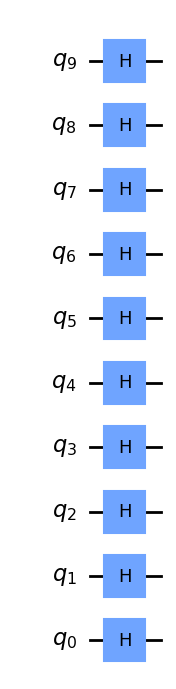

In [5]:
state_preparation = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    state_preparation.h(i)

state_preparation.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Oracle operator</font></h1>

We can construct a **phase oracle** from a _dimacs_ file with **PhaseOracle** class of Qiskit, but due to issue [4] we are going to import the **Oracle** from the __aux_func.py__ file. Then we show it.

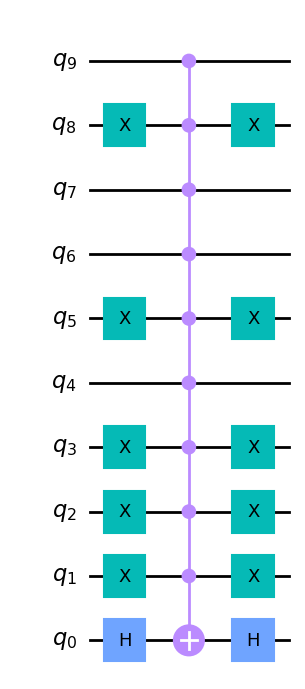

In [6]:
oracle.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Grover operator (Oracle + Inversion about the mean)</font></h1>

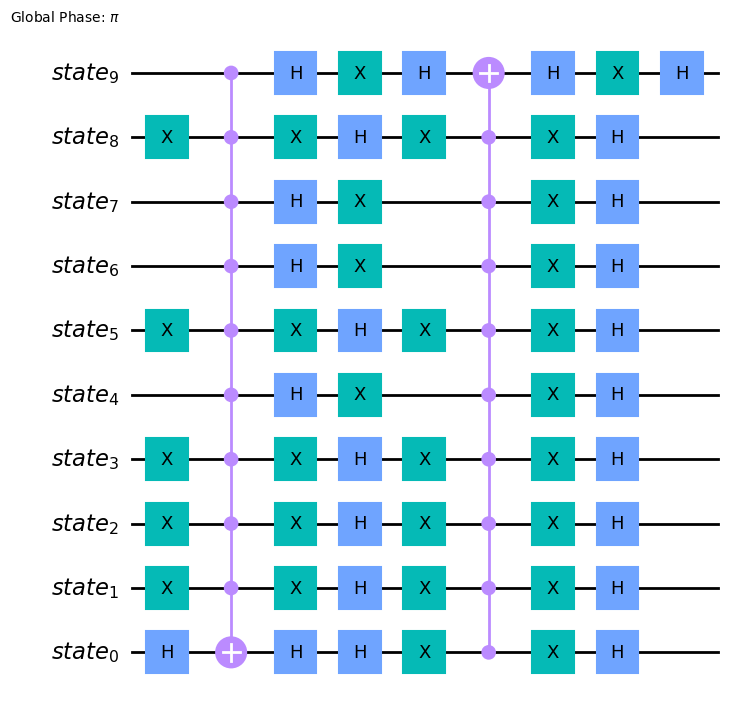

In [7]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Number of iterations</font></h1>

In [8]:
iterations = calculate_iterations(2**N_QUBITS)
print("Number of iterations needed: ", iterations)

Number of iterations needed:  24.62864948087203


The number of iterations needed is **25** (rounded to the nearest integer). Now, we are going to execute **Grover's algorithm**:

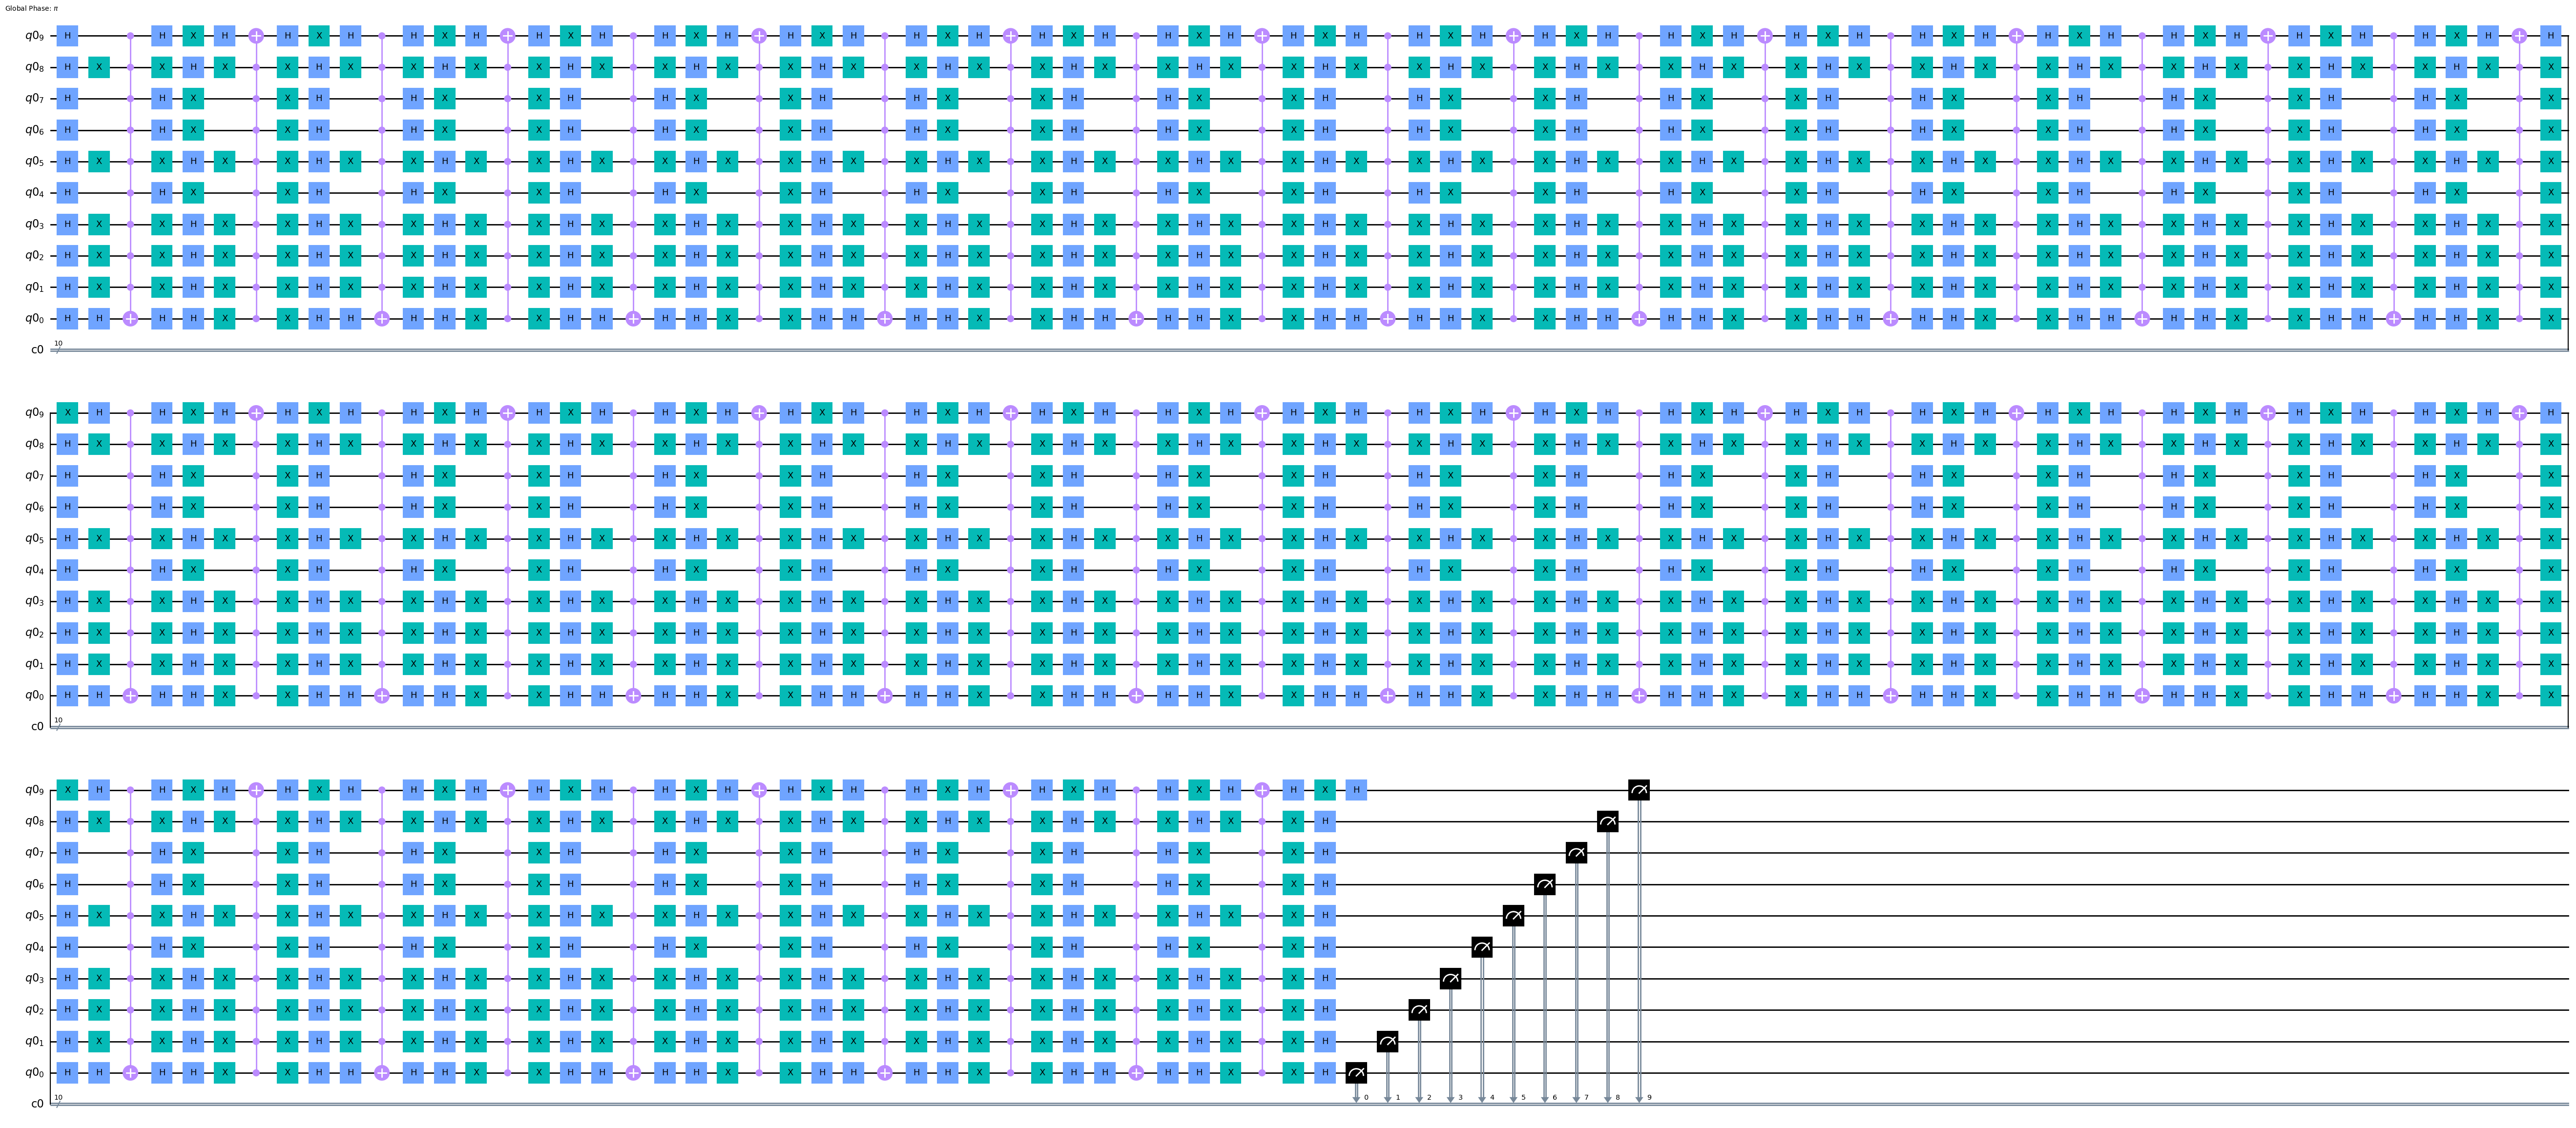

{'1011010001': 10}


In [9]:
# Quantum and Classical Registers setup
q_reg = QuantumRegister(N_QUBITS)
c_reg = ClassicalRegister(N_QUBITS)

# Quantum Circuit creation for Grover's algorithm
grover_circ = QuantumCircuit(q_reg, c_reg)

# Apply state preparation to the quantum circuit
grover_circ.compose(state_preparation, wrap=False, inplace=True)

# Apply 25 iterations of the Grover operator to the circuit
for _ in range(25):
    grover_circ.compose(grover_op.decompose(), wrap=False, inplace=True)

# Measure all qubits in the circuit
grover_circ.measure([i for i in range(N_QUBITS)], [i for i in range(N_QUBITS)])

# Display the circuit
display(grover_circ.draw(output='mpl', reverse_bits=True, fold=80))

# Execute the circuit and get the results
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(grover_circ.decompose(reps=2), seed_simulator=SEED, shots=N_SHOTS).result().get_counts()
print(counts)

In [10]:
print("The solution state is: 1011010001 ({int_state})".format(int_state=int('1011010001', 2)))

The solution state is: 1011010001 (721)


<h1><font color='#020e34' size=4>Checking the solution</font></h1>

Now we are going to check the solution:

In [11]:
print("Does the solution satisfy the Boolean formula?:", is_satisfied(cnf_problem, 721))

Does the solution satisfy the Boolean formula?: True



<h1><font color='#020e34' size=5>Neighborhood Quantum Superposition approach</font></h1>
<h1><font color='#020e34' size=4>Grover's modified algorithm</font></h1>

Next, we will solve the problem by reducing the number of states in the problem domain using **Neighborhood Quantum Superposition**. To achieve this, we need to modify the **Initial State Operator** of the **Grover's** algorithm and replace the **Hadamard** gates with the operator obtained through **Neighborhood Quantum Superposition**. Additionally, we will also need to modify the **Inversion About the Mean Operator** to operate over the subspace of generated states. We will be guided by the **Grover's algorithm** version described in [5].

To generate the initial superposition, we need to determine which subset of all possible states we want. To do this, we require a **reference state** from which to generate the neighborhood, the **metric** used to generate the neighborhood, and the **distances** of the states we want to superpose.

In our case, to determine which state we want as a reference, we will calculate it by generating random states and selecting the one that satisfies the most clauses. Note that the heuristic is a parameter to investigate and will have a significant impact on the improvement we can achieve in solving the problem. For our case, we have chosen a simple and fast heuristic. We also can use **Quantum annealing** as heuristic to get a **reference state** as we can see in [6].

From the available metrics, including **Hamming** distance, **Ample** similarity, **Cosine** similarity, **Simpson** similarity, **Johnson** similarity, **Pearson I** similarity, **Jaccard** similarity, **Dice** similarity, **Tanimoto** similarity, we have chosen the **Jaccard** distance.

<img src="./files/grover_modified.png" alt="Grover modified algorithm" align="center" width=900>

Now, we are going to generate a total of **5** random states that is a half of the number of variables in the problem. Then we are going to show the number of satified clauses for each state, the random states with a line in blue and the solution state with a line in purple.

The state 787 satisfies a total of 37 clauses
The state 860 satisfies a total of 38 clauses
The state 81 satisfies a total of 40 clauses
The state 529 satisfies a total of 39 clauses
The state 994 satisfies a total of 39 clauses


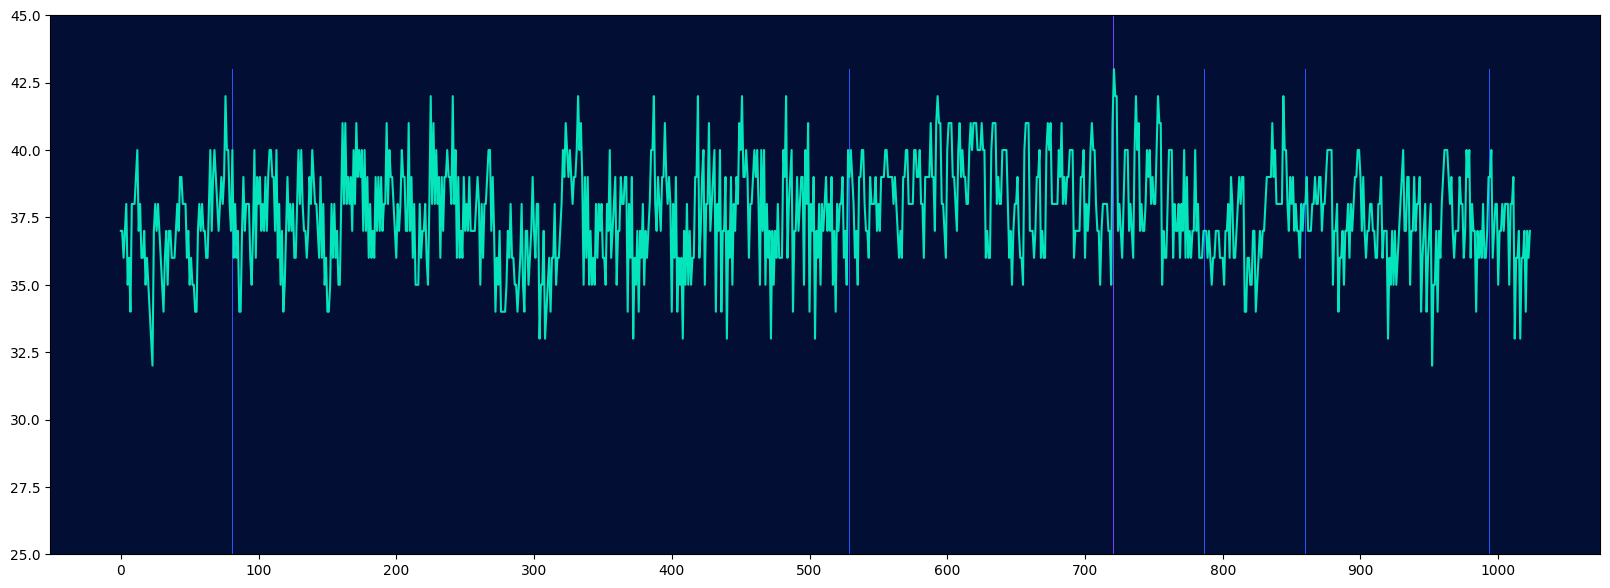

In [12]:
random.seed(SEED)

n_random_states = cnf_problem.nv // 2
random_states = [random.randrange(2**cnf_problem.nv) - 1 for _ in range(n_random_states)]

for state in random_states:
    print("The state {state} satisfies a total of {clauses} clauses".format(state=state, clauses=n_satisfied_clauses(cnf_problem, state)))
    
plot_max_sat(cnf_problem, 721, random_states)

As we can see, the random state that most clauses satisfies is **81**. For the distances of the states we want to superpose, we will choose distances that span $\approx 25\%$ of the total domain. The distances that satisfy this condition are **7/20** and **inf**, with a total of 207 states.

In [13]:
# Initialize QsimovCloudClient with your access token
client = QsimovCloudClient('YOUR_API_TOKEN')

# Set parameters for the service
client.set_metric("jaccard")
client.set_state(state_bin=format(81, '0'+str(N_QUBITS)+'b'))
client.can_have_nan(False)
client.set_ancilla_mode("clean")

# Choose a range for the superposition (both included)
range_metric = ('7/20', 'inf')
client.set_range(range_metric)

# Generate a quantum circuit (comment the next line if you don't have an API token)
circuit_superposition = client.generate_circuit()

# If you don't have an API token to make the request to the service,
# what are you waiting for? Obtain one and replace 'YOUR_API_TOKEN'.
# Until you get it, uncomment the following line to proceed with the notebook execution.

#circuit_superposition = superposition_circuit_jaccard

In [14]:
# Access the result
print("Number of extra qubits", circuit_superposition.get_extra_qubits())
print("Number of superposed states", circuit_superposition.get_num_superposed())
print("The resulting circuit in qasm is:\n", circuit_superposition.get_qasm_code()[:1000])

Number of extra qubits 5
Number of superposed states 207
The resulting circuit in qasm is:
 OPENQASM 2.0;
include "qelib1.inc";
gate gate__gate q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14 { u3(2.3743202364564904,0,0) q0; ccx q0,q13,q14; cx q0,q13; u3(pi/2,0,pi) q1; u3(pi,0,pi) q10; u3(pi,0,pi) q11; cx q1,q11; u3(0,0,-pi/4) q11; cx q10,q11; u3(0,0,pi/4) q11; cx q1,q11; u3(0,0,-pi/4) q11; cx q10,q11; u3(pi/2,pi/4,-3*pi/4) q11; u3(pi,0,pi) q12; u3(pi,0,pi) q13; u3(pi,0,pi) q14; cx q14,q11; u3(0,0,-pi/4) q11; cx q13,q11; u3(0,0,pi/4) q11; cx q14,q11; u3(pi/2,-pi/4,3*pi/4) q11; cx q10,q11; u3(0,0,pi/4) q11; cx q1,q11; u3(0,0,-pi/4) q11; cx q10,q11; u3(0,0,pi/4) q11; cx q1,q11; u3(1.3140033719793796,0,-pi) q1; u3(pi/2,pi/4,-pi) q11; cx q14,q11; u3(0,0,-pi/4) q11; cx q13,q11; u3(0,0,pi/4) q11; cx q14,q11; u3(pi/2,0,3*pi/4) q11; ccx q11,q12,q1; u3(1.3140033719793796,0,-pi) q1; cx q1,q11; u3(0,0,-pi/4) q11; cx q10,q11; u3(0,0,pi/4) q11; cx q1,q11; u3(0,0,-pi/4) q11; cx q10,q11; u3(pi/2,pi

<h1><font color='#020e34' size=4>Initial state operator</font></h1>

We construct the operator from the **QASM** code received.

In [15]:
# Creates the Qiskit circuit from qasm code
state_preparation = QuantumCircuit.from_qasm_str(circuit_superposition.get_qasm_code()).decompose()
state_preparation.name = "Initial state"

<h1><font color='#020e34' size=4>Oracle operator expanded</font></h1>

As we need 5 more qubits in the **Q** operator for initial superposition, we need to expand the **Oracle** to match the size of the new circuit. Then we show it.

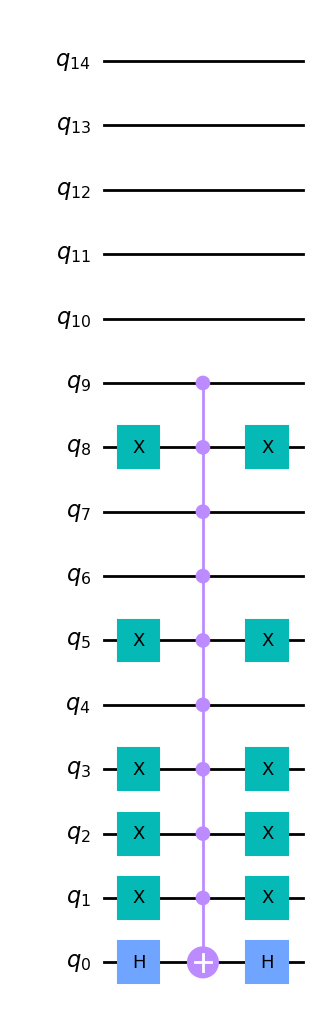

In [16]:
oracle_expanded = QuantumCircuit(N_QUBITS + circuit_superposition.get_extra_qubits()) 
oracle_expanded.append(oracle, [i for i in range(N_QUBITS)])
oracle_expanded.decompose().draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Grover operator (Oracle + Inversion about the mean)</font></h1>

For the new **Inversion about the mean** we need to pass the **Initial state operator** to the **GroverOperator** class.

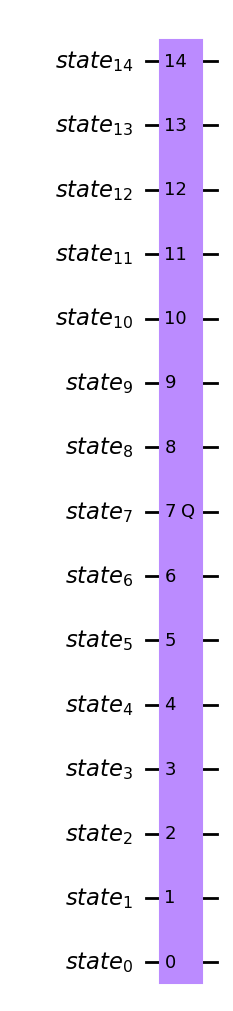

In [17]:
grover_neighborhood_op = GroverOperator(oracle_expanded, reflection_qubits=[i for i in range(N_QUBITS)], insert_barriers=True, state_preparation=state_preparation)
grover_neighborhood_op.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Number of iterations</font></h1>

In [18]:
iterations = calculate_iterations(circuit_superposition.get_num_superposed())
print("Number of iterations needed: ", iterations)

Number of iterations needed:  10.790801169249837


The number of iterations needed is **11** (rounded to the nearest integer). Now, we are going to execute **Grover's modified algorithm**:

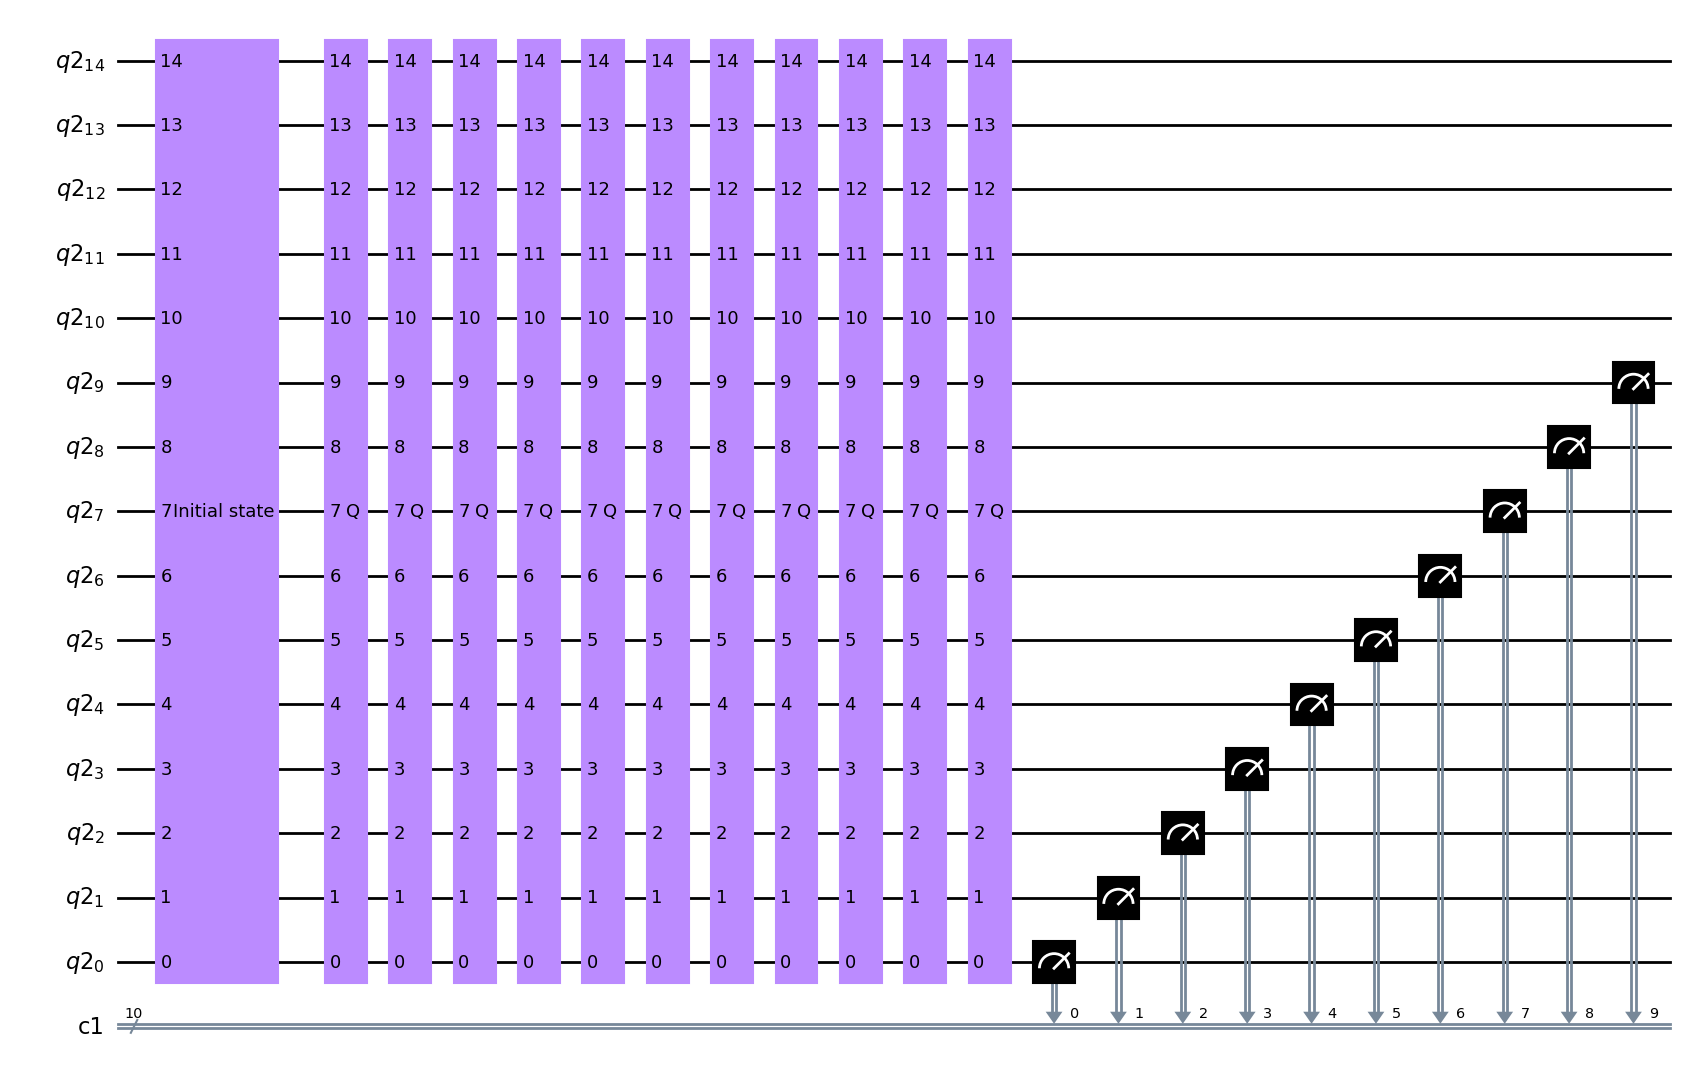

{'1011010001': 10}


In [19]:
# Quantum and Classical Registers setup
q_mod_reg = QuantumRegister(N_QUBITS + circuit_superposition.get_extra_qubits())
c_mod_reg = ClassicalRegister(N_QUBITS)

# Quantum Circuit creation for Grover's modified algorithm
grover_mod_circ = QuantumCircuit(q_mod_reg, c_mod_reg)

# Apply state preparation to the quantum circuit
grover_mod_circ.compose(state_preparation, wrap=True, inplace=True)

# Apply 11 iterations of the Grover operator to the circuit
for _ in range(11):
    grover_mod_circ.compose(grover_neighborhood_op, wrap=True, inplace=True)

# Measure input qubits in the circuit
grover_mod_circ.measure([i for i in range(N_QUBITS)], [i for i in range(N_QUBITS)])

# Display the circuit
display(grover_mod_circ.draw(output='mpl', reverse_bits=True))

# Execute the circuit and get the results
backend = Aer.get_backend('qasm_simulator')
counts_modified = backend.run(grover_mod_circ.decompose(reps=3), seed_simulator=SEED, shots=N_SHOTS).result().get_counts()
print(counts_modified)

In [20]:
print("The solution state is: 1011010001 ({int_state})".format(int_state=int('1011010001', 2)))

The solution state is: 1011010001 (721)


<h1><font color='#020e34' size=4>Checking the solution</font></h1>

Now we are going to check the solution:

In [21]:
print("Does the solution satisfy the Boolean formula?:", is_satisfied(cnf_problem, 721))

Does the solution satisfy the Boolean formula?: True


# Results and Implications

The results speak for themselves. With **Neighborhood Quantum Superposition**, the **3-SAT problem** is solved with increased efficiency. Fewer iterations are required. 

This is a very simple use case, the parts of the algorithm where one can investigate and reduce the algorithm's complexity are:

- Number of **shots**.
- The **metric** used.
- The **problem domain size**.
- The **heuristic** for the reference state.

# References

[1] Grover, L. K. (1996). "A Fast Quantum Mechanical Algorithm for Database Search". In Proceedings of the Twenty-Eighth Annual ACM Symposium on Theory of Computing (STOC '96) (pp. 212–219). Association for Computing Machinery.

[2] Cook, S. A. (1971). "The Complexity of Theorem-Proving Procedures". In Proceedings of the Third Annual ACM Symposium on Theory of Computing (STOC '71) (pp. 151–158). Association for Computing Machinery. New York, NY, USA.

[3] Mitchell, D., Selman, B., & Levesque, H. (1992). "Hard and Easy Distributions of SAT Problems". In Proceedings Tenth National Conference on Artificial Intelligence.

[4] Qiskit. (Jun 30, 2021). ["PhaseOracle.from_dimacs_file() returns "Index out of range" error #6734"][tweedledum-bug]. GitHub. 

[5] Grover, L. K. (1998, may). "Quantum Computers Can Search Rapidly by Using Almost Any Transformation". Phys. Rev. Lett., 80(19), 4329–4332. 

[6] Paulet, J. J., LLana, L. F., de la Cruz, H. I., Mezzini, M., Cuartero, F., & Pelayo, F. L. (2023). ["A hybrid Quantum proposal to deal with 3-SAT problem"][annealing-circuits]. arXiv preprint arXiv:2306.04378.

[tweedledum-bug]: https://github.com/Qiskit/qiskit/issues/6734
[annealing-circuits]: https://arxiv.org/abs/2306.04378
